In [1]:
import h5py
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import *
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from sklearn.metrics import roc_curve, auc
import tensorflow.keras.backend as K
import time
#import joblib

# compute a mask per event, and attach vec(0) for the first MLP output for those masked
# so S and pho steps are unchanged, but skipping first MLP computations
# the total dim N * D is still the same after the first MLP (those zero constituents are skipping phi)
# --> for zero-padded constituents, directly make D-dim zeros for them after the first MLP
# make a route:
# if mask == 0:
#     pass to first MLP
# else:
#     make D-dim zeros

# number of jet constituents
N = 32

with h5py.File('data.h5', 'r') as f:
    x = f['x'][:, :N, :]
    y = f['y'][:]

# min pt cut on jet constituents
x[x[:, :, 0] < 2] = 0

# normalization of the pt feature by interquantile range
q5 = np.percentile(x[:, :, 0], 5)
q95 = np.percentile(x[:, :, 0], 95)
x[:, :, 0] = (x[:, :, 0] - 0) / (q95 - q5)

train_ratio = 0.4
val_ratio = 0.1
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test, Y_train_val, Y_test = train_test_split(x, y, test_size = test_ratio, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 42)
print('X_train shape: ' + str(X_train.shape))
print('X_val   shape: ' + str(X_val.shape))
print('X_test  shape: ' + str(X_test.shape))
print('Y_train shape: ' + str(Y_train.shape))
print('Y_val   shape: ' + str(Y_val.shape))
print('Y_test  shape: ' + str(Y_test.shape))
del X_train_val, Y_train_val

X_train shape: (352000, 32, 3)
X_val   shape: (88000, 32, 3)
X_test  shape: (440000, 32, 3)
Y_train shape: (352000, 5)
Y_val   shape: (88000, 5)
Y_test  shape: (440000, 5)


In [2]:
phi_dim = 32
rho_dim = 32

def build_phi():
    input_constituent = layers.Input(shape=(N, 3), name='phi_input')
    x = layers.Dense(phi_dim, activation='relu', use_bias=True, name='phi1')(input_constituent)
    x = layers.Dense(phi_dim, activation='relu', use_bias=True, name='phi2')(x)
    x = layers.Dense(phi_dim, activation='relu', use_bias=True, name='phi3')(x)
    return models.Model(input_constituent, x, name="phi")

def build_rho():
    input_agg = layers.Input(shape=(phi_dim,), name='rho_input')
    x = layers.Dense(rho_dim, activation='relu', use_bias=True, name='rho1')(input_agg)
    x = layers.Dense(5, activation='softmax', use_bias=True, name='rho2')(x)
    return models.Model(input_agg, x, name="rho")

phi = build_phi()
rho = build_rho()

input_constituent = layers.Input(shape=(N, 3))
phi_output = phi(input_constituent)
agg = layers.GlobalMaxPooling1D()(phi_output)
rho_output = rho(agg)

model = models.Model(input_constituent, rho_output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ phi (Functional)                │ (None, 32, 32)         │         2,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rho (Functional)                │ (None, 5)              │         1,221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,461 (13.52 KB)

 Trainable params: 3,461 (13.52 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    epochs=20, batch_size=128)

Epoch 1/20
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5685 - loss: 1.0802 - val_accuracy: 0.6672 - val_loss: 0.8971
Epoch 2/20
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6717 - loss: 0.8874 - val_accuracy: 0.6896 - val_loss: 0.8578
Epoch 3/20
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6821 - loss: 0.8669 - val_accuracy: 0.6892 - val_loss: 0.8555
Epoch 4/20
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6868 - loss: 0.8552 - val_accuracy: 0.6779 - val_loss: 0.8750
Epoch 5/20
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6866 - loss: 0.8559 - val_accuracy: 0.6981 - val_loss: 0.8408
Epoch 6/20
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6918 - loss: 0.8482 - val_accuracy: 0.7011 - val_loss: 0.8289
Epoch 7/20
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6916 - loss: 0.8442 - val_accuracy: 0.6986 - val_loss: 0.8386
Epoch 8/20
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6941 - loss: 0.8411 - 

Text(0, 0.5, 'Loss')

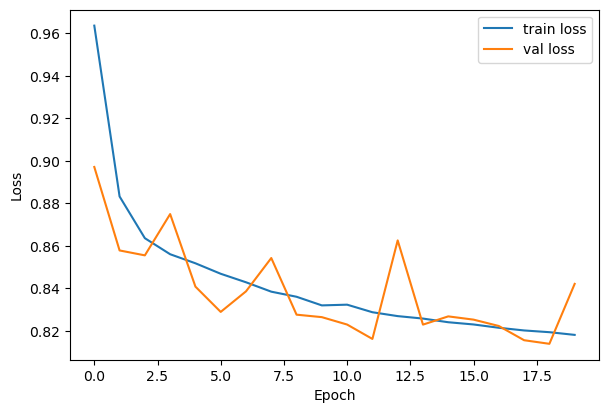

In [4]:
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [5]:
Y_pred = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))))

13750/13750 ━━━━━━━━━━━━━━━━━━━━ 4s 313us/step
Accuracy: 0.6931363636363637


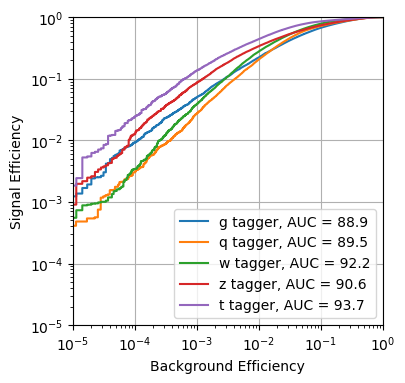

In [10]:
def plot_roc(y_test, y_pred, labels):
    for x, label in enumerate(labels):        
        fpr, tpr, _ = roc_curve(y_test[:, x], y_pred[:, x])
        plt.plot(fpr, tpr, label='{0} tagger, AUC = {1:.1f}'.format(label, auc(fpr, tpr)*100.), linestyle='-')
    plt.semilogy()
    plt.semilogx()
    plt.ylabel("Signal Efficiency")
    plt.xlabel("Background Efficiency")
    plt.ylim(0.00001, 1)
    plt.xlim(0.00001, 1)
    plt.grid(True)
    plt.legend(loc='best')  
    
plt.figure(figsize=(4, 4))
plot_roc(Y_test, Y_pred, ['g','q','w','z','t'])

In [7]:
model.save('model.keras')

In [8]:
model = tf.keras.models.load_model('model.keras')

In [9]:
Y_pred = model.predict(X_test)

13750/13750 ━━━━━━━━━━━━━━━━━━━━ 4s 313us/step


In [ ]:
phi_layer = model.get_layer('time_distributed').layer
X_test_mask = layers.Masking(mask_value=0.)(X_test)
phi_outputs_mask = layers.TimeDistributed(phi_layer)(X_test_mask)
agg_mask = model.layers[2](phi_outputs_mask)
Y_pred_mask = model.layers[3](agg_mask)

In [ ]:
print("Accuracy: {}".format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))))

In [ ]:
print("Accuracy: {}".format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_mask, axis=1))))

In [ ]:
Y_pred_mask

In [ ]:
Y_pred